Summary:
* loading 2 views from BigStitcher H5 file (stacks are already unsheared)
* resampling to isotropic resolution
* basic coordinate transform of view1 to match coordinates of view0
* rotation of both views 45-deg around X-axis, to make the worm fit a box.
* cropping worm body to head region based on Otsu threashold estimator 
* worm head registration (rigid)
* mv-deconvolution with Richardson-Lucy: single bead, then worm head

In [1]:
import SimpleITK as sitk
%matplotlib inline
import matplotlib.pyplot as plt
import os
import h5py
import numpy as np
import util
import importlib
import registration_callbacks
from skimage.external import tifffile as tif
import npy2bdv
from IPython.display import display, HTML 
from tqdm.notebook import tqdm

C:\Users\nvladim\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dirname_data = './datasets/2019-03-05/'
fname_xml = dirname_data + 'dataset.xml'
fname_h5 = dirname_data + 'dataset.h5'

In [3]:
reader = npy2bdv.BdvReader(fname_h5)

In [4]:
view0arr = reader.read_view(time=0, isetup=0)
view1arr = reader.read_view(time=0, isetup=1)

In [5]:
print(view0arr.shape)
print(view1arr.shape)
print(view0arr.dtype)
print(view1arr.dtype)
print(f"v0 min, max, mean: {view0arr.min()}, {view0arr.max()}, {view0arr.mean()}")
print(f"v1 min, max, mean: {view1arr.min()}, {view1arr.max()}, {view1arr.mean()}")

(80, 220, 893)
(80, 316, 836)
uint16
uint16
v0 min, max, mean: 0, 2405, 128.2822432683498
v1 min, max, mean: 0, 2730, 130.48316037414452


In [6]:
voxel_xyz = [0.14625, 0.14625, 1.1115]
cam_offset = 100.

In [7]:
view0_original =  sitk.GetImageFromArray(view0arr)
view1_original = sitk.GetImageFromArray(view1arr) 

view0_original.SetSpacing(voxel_xyz)
view1_original.SetSpacing(voxel_xyz)

In [8]:
#Check min-max values
print(util.get_minmax(view0_original))
print(util.get_minmax(view1_original))

(0.0, 2405.0)
(0.0, 2730.0)


### Skew and other basic transforms

In [9]:
dimension = 3
transform_shear0 = sitk.AffineTransform(dimension)
transform_shear1 = sitk.AffineTransform(dimension)

x_shear_0 = x_shear_1 = 0.0 #in spatial units
matrix = np.array(transform_shear0.GetMatrix()).reshape((dimension,dimension))
matrix[0,2] = x_shear_0
transform_shear0.SetMatrix(matrix.ravel())
matrix[0,2] = x_shear_1
transform_shear1.SetMatrix(matrix.ravel())

# Reverse X, Y axes signs, because of the mirror image the microscope produces in view1
transform_flipYsign = sitk.AffineTransform(dimension)
matrix = np.array([1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0])
transform_flipYsign.SetMatrix(matrix)

# rotate 90 deg around Y
transform_rot_around_Y = sitk.AffineTransform(dimension)
transform_rot_around_Y.Rotate(axis1=0, axis2=2, angle=-np.pi/2)

The stacks are already unsheared, so we proceed to resampling and coordinate transforms.

In [10]:
# view0_unsheared = util.transform_resample(view0_original, transform_shear0, default_val=cam_offset)
# view1_unsheared = util.transform_resample(view1_original, transform_shear1, default_val=cam_offset)

view0_unsheared = view0_original
view1_unsheared = view1_original

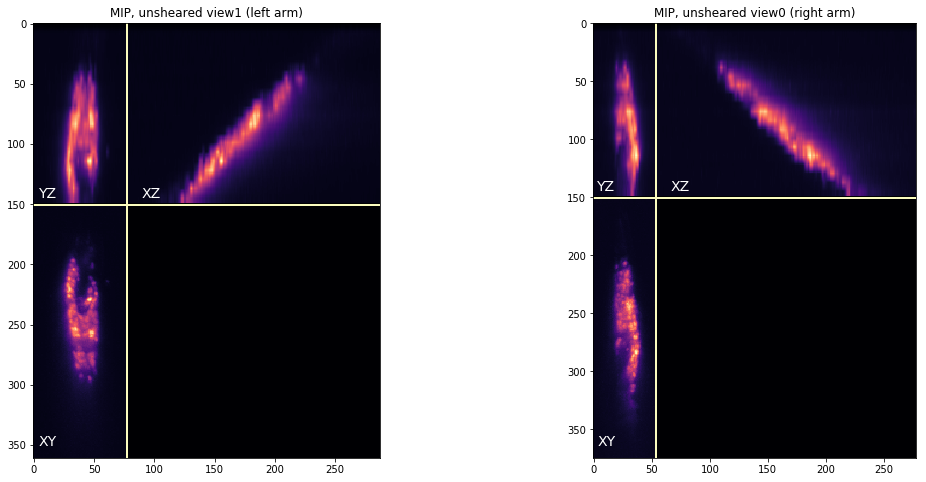

In [11]:
fig = plt.figure(figsize=(18,8))
fig.add_subplot(1,2,1)
util.show_mips(util.downsample(view1_unsheared, 4),'MIP, unsheared view1 (left arm)', cmap='magma')

fig.add_subplot(1,2,2)
util.show_mips(util.downsample(view0_unsheared, 4),'MIP, unsheared view0 (right arm)', cmap='magma')

Resample to isotropic voxel size:

In [14]:
view0_iso = util.resample_isotropic(view0_unsheared, default_val=cam_offset)
view1_iso = util.resample_isotropic(view1_unsheared, default_val=cam_offset)

Now transform view1 coordinates to match them to view0:

In [15]:
view1_coordinate_transform = sitk.Transform(transform_rot_around_Y)
view1_coordinate_transform.AddTransform(transform_flipYsign)

view1_iso_matched = util.transform_resample(view1_iso, view1_coordinate_transform, default_val=cam_offset)

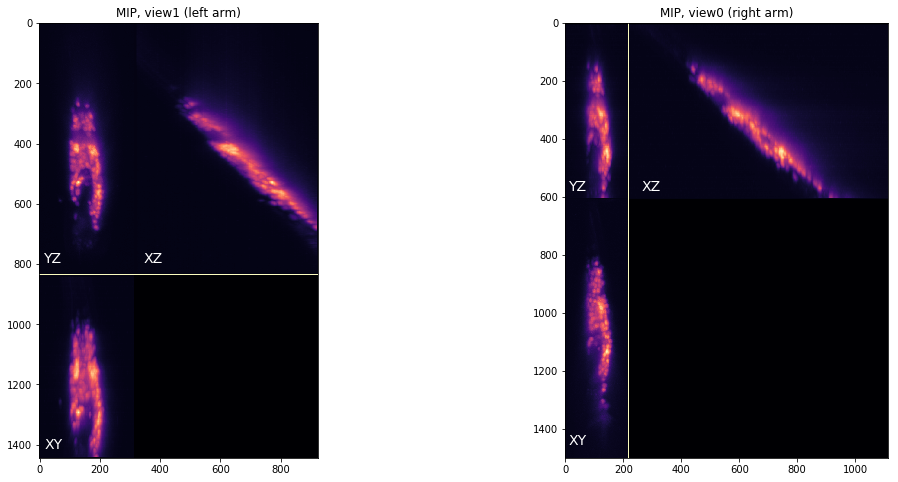

In [16]:
fig = plt.figure(figsize=(18,8))
fig.add_subplot(1,2,1)
util.show_mips(view1_iso_matched, 'MIP, view1 (left arm)', cmap='magma')

fig.add_subplot(1,2,2)
util.show_mips(view0_iso, 'MIP, view0 (right arm)', cmap='magma')

In [17]:
# clean up
del view0_original, view1_original, view1_iso, view0_unsheared, view1_unsheared

### Rotate both views 45-deg around X-axis to make worm fit a rectangular box

In [18]:
transform_rotY_45 = sitk.AffineTransform(dimension)
transform_rotY_45.Rotate(axis1=0, axis2=2, angle=-np.pi/4)

# Apply the transform
view0_flat = util.transform_resample(view0_iso, transform_rotY_45, default_val=cam_offset)
#del view0_iso
view1_flat = util.transform_resample(view1_iso_matched, transform_rotY_45, default_val=cam_offset)
#del view1_iso_matched

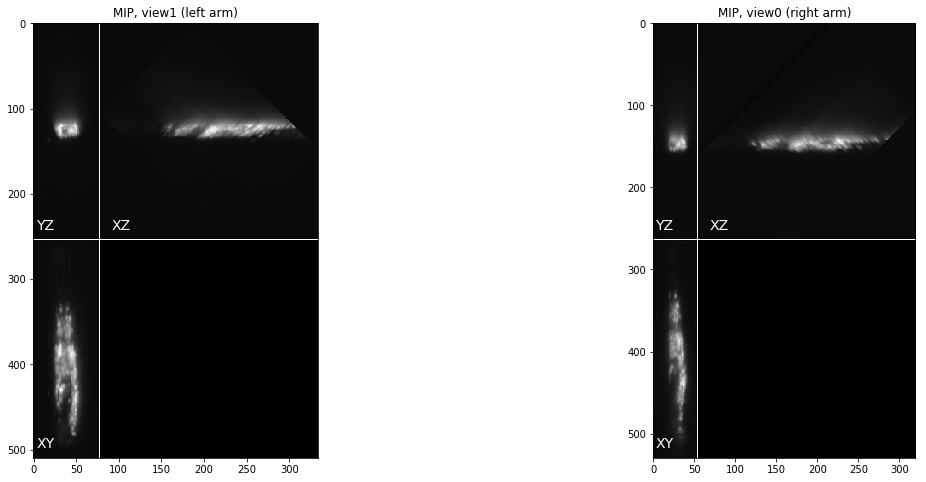

In [19]:
# replot
fig = plt.figure(figsize=(20,8))
fig.add_subplot(1,2,1)
util.show_mips(util.downsample(view1_flat, 4),'MIP, view1 (left arm)')

fig.add_subplot(1,2,2)
util.show_mips(util.downsample(view0_flat, 4),'MIP, view0 (right arm)')

There is a lot of empty space around the worm, which must be cropped to save time in registration and deconvolution (this can give 10x or more speed-up).

In [20]:
view0_cropped, _, _ = util.threshold_based_crop(view0_flat, padding_px=20)
view1_cropped, _, _ = util.threshold_based_crop(view1_flat, padding_px=20)

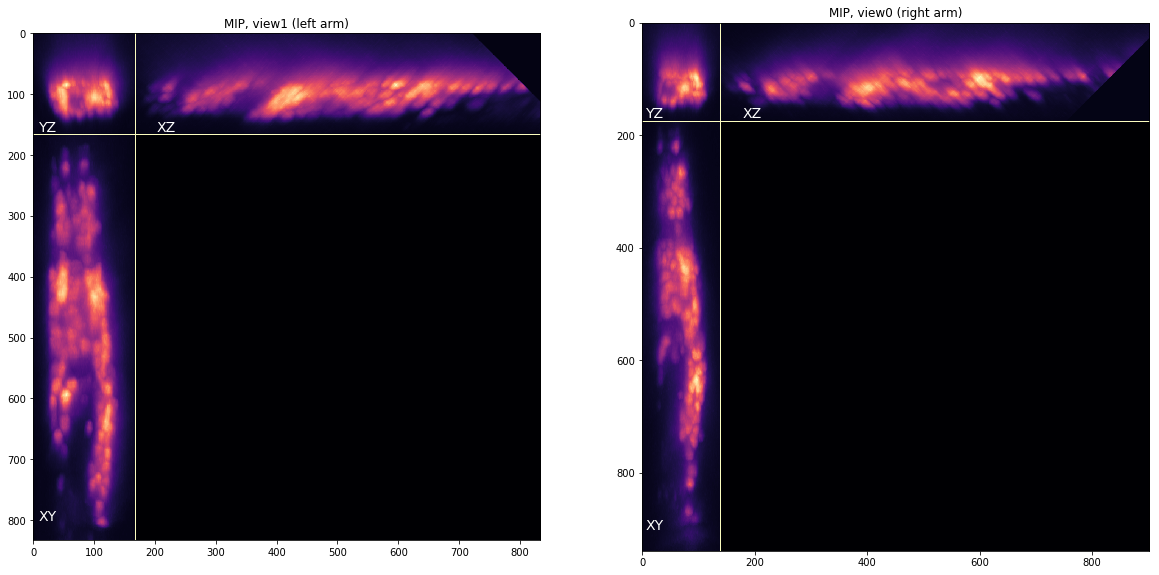

In [23]:
# replot vertically to see details
fig = plt.figure(figsize=(20,12))
fig.add_subplot(1,2,1)
util.show_mips(view1_cropped,'MIP, view1 (left arm)', cmap='magma')

fig.add_subplot(1,2,2)
util.show_mips(view0_cropped,'MIP, view0 (right arm)', cmap='magma')

In [24]:
del view0_flat, view1_flat

### Rigid registration of view1 (moving) to view0 (fixed)

In [25]:
initial_transform = sitk.CenteredTransformInitializer(util.downsample(view0_cropped, 2), 
                                                      util.downsample(view1_cropped, 2), 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.MOMENTS)

view1_initial = util.transform_resample(view1_cropped, initial_transform, default_val=cam_offset)
view1_resampled = util.resample_moving2fixed(view0_cropped, view1_initial, default_val=cam_offset)

In [26]:
img_merge = util.merge_images_rgb(view0_cropped, view1_resampled)

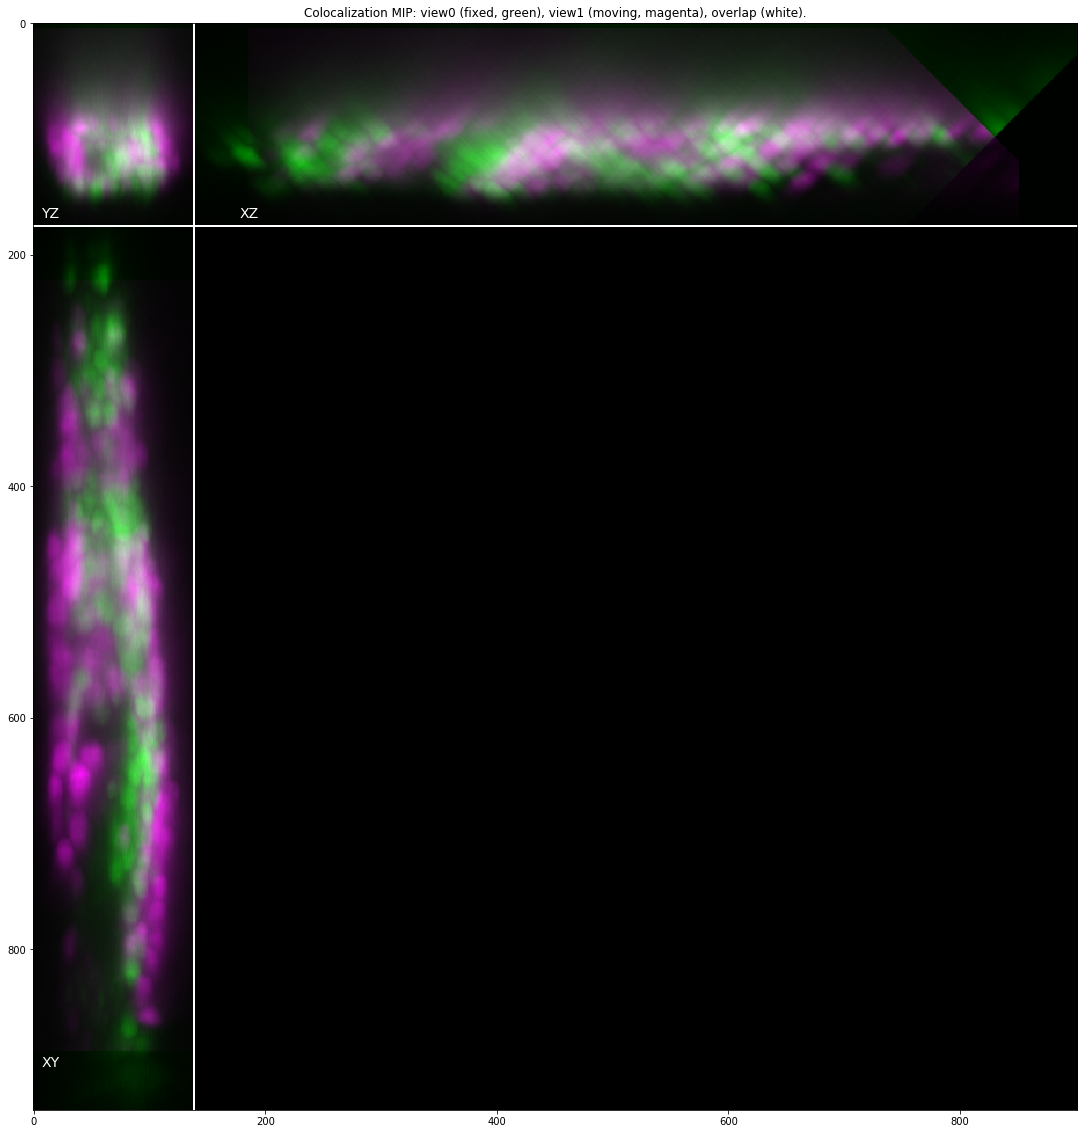

In [27]:
fig = plt.figure(figsize=(20,20))
util.show_mips(img_merge, "Colocalization MIP: view0 (fixed, green), view1 (moving, magenta), overlap (white).")

In [39]:
# optional: launch and inspect in Fiji
sitk.Show(img_merge)

In [28]:
del view1_initial, view1_resampled

In [29]:
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMeanSquares()
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25) #, estimateLearningRate=registration_method.EachIteration)
registration_method.SetOptimizerScalesFromPhysicalShift() 

In [30]:
final_transform = sitk.Euler3DTransform(initial_transform)
registration_method.SetInitialTransform(final_transform)
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [16, 8, 4])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

In [31]:
%%time
#registration_method.AddCommand(sitk.sitkStartEvent, registration_callbacks.metric_start_plot)
#registration_method.AddCommand(sitk.sitkEndEvent, registration_callbacks.metric_end_plot)
#registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
#                               registration_callbacks.metric_update_multires_iterations) 
#registration_method.AddCommand(sitk.sitkIterationEvent, 
#                               lambda: registration_callbacks.metric_plot_values(registration_method))

registration_method.Execute(sitk.Cast(view0_cropped, sitk.sitkFloat32), 
                            sitk.Cast(view1_cropped, sitk.sitkFloat32))

Wall time: 2min 36s


<SimpleITK.SimpleITK.Transform; proxy of <Swig Object of type 'itk::simple::Transform *' at 0x000001BF0299DED0> >

In [32]:
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))

Optimizer's stopping condition, PowellOptimizerv4: Cost function values at the current parameter (33644.8) and at the local extrema (33644.8) are within Value Tolerance (1e-06)
Final metric value: 33644.818457894355


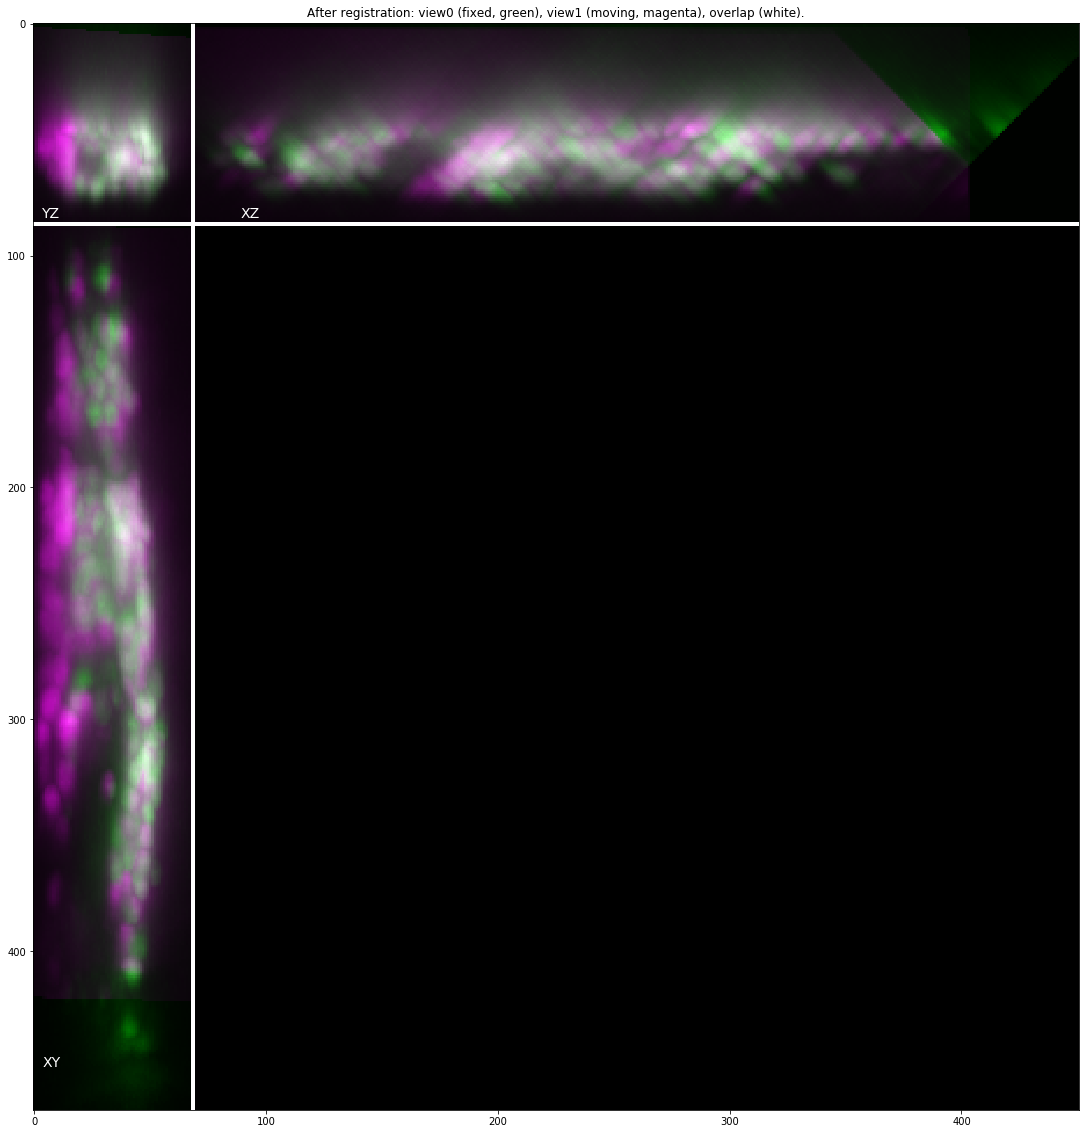

In [33]:
view1_cropped_registered = sitk.Resample(view1_cropped, view0_cropped, final_transform, 
                                           sitk.sitkLinear, 0.0, view0_cropped.GetPixelID())

img_merge = util.merge_images_rgb(util.downsample(view0_cropped, 2), util.downsample(view1_cropped_registered, 2))

fig = plt.figure(figsize=(20,20))
util.show_mips(img_merge, "After registration: view0 (fixed, green), view1 (moving, magenta), overlap (white).")

In [33]:
# optional: launch and inspect in Fiji
sitk.Show(img_merge)

In [70]:
# save the images and registration
# subfolder_name = 'sitk'
# suffix = '_2020.09.07'
# if not os.path.exists(dirname_data + subfolder_name):
#     os.mkdir(dirname_data + subfolder_name)

# util.save_transform(final_transform, dirname_data + subfolder_name + '/view1_final_transform' + suffix)

# sitk.WriteImage(view0_cropped, dirname_data + subfolder_name + '/view0_cropped' + suffix + '.mhd')
# sitk.WriteImage(view1_cropped_registered, dirname_data + subfolder_name + '/view1_cropped_registered' + suffix + '.mhd')

In [272]:
# Load the images
# view0_cropped = sitk.ReadImage(dirname_data + subfolder_name + '/view0_cropped' + suffix + '.mhd')
# view1_cropped = sitk.ReadImage(dirname_data + subfolder_name + '/view1_cropped_registered' + suffix + '.mhd')
#final_transform = sitk.ReadTransform(dirname_data + subfolder_name + '/view1_final_transform' + suffix +'.tfm')

In [35]:
# or, rename if running online session
view1_cropped = view1_cropped_registered 

In [37]:
print(view0_cropped.GetSize())
print(view1_cropped.GetSize())

#Check min-max values
print(util.get_minmax(view0_cropped))
print(util.get_minmax(view1_cropped))

(762, 140, 177)
(762, 140, 177)
(73.0, 2375.0)
(0.0, 2583.0)


### Affine registration

Based on this [code](https://github.com/nvladimus/ITK_sandbox)

In [38]:
fixed_image = sitk.Cast(view0_cropped, sitk.sitkFloat32)
moving_image = sitk.Cast(view1_cropped, sitk.sitkFloat32)
affine_transform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.AffineTransform(3), 
                                                     sitk.CenteredTransformInitializerFilter.GEOMETRY)

In [39]:
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsCorrelation()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=300)
# Scale the step size differently for each parameter, this is critical!!!
registration_method.SetOptimizerScalesFromPhysicalShift() 
registration_method.SetInitialTransform(affine_transform, inPlace=True)
# registration_method.AddCommand(sitk.sitkStartEvent, registration_callbacks.metric_start_plot)
# registration_method.AddCommand(sitk.sitkEndEvent, registration_callbacks.metric_end_plot)
# registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
#                               registration_callbacks.metric_update_multires_iterations) 
# registration_method.AddCommand(sitk.sitkIterationEvent, 
#                               lambda: registration_callbacks.metric_plot_values(registration_method))

registration_method.Execute(fixed=fixed_image, moving=moving_image)
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 118.
Final metric value: -0.7428017517537046


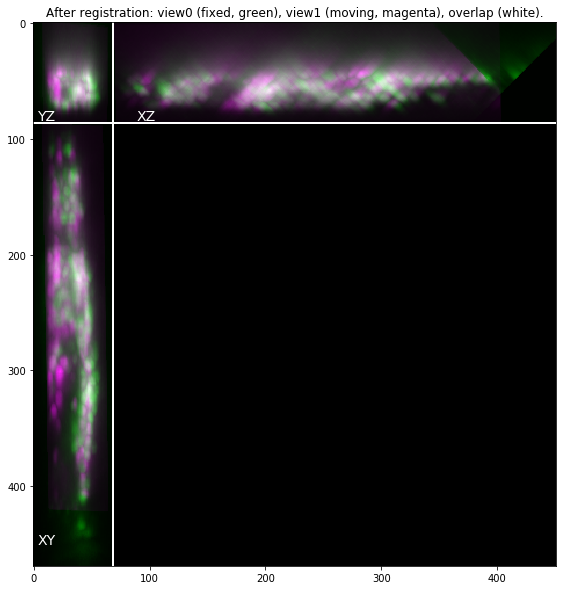

In [40]:
view1_cropped_affine = sitk.Resample(view1_cropped, view0_cropped, affine_transform, 
                                           sitk.sitkLinear, 0.0, view0_cropped.GetPixelID())

img_merge = util.merge_images_rgb(util.downsample(view0_cropped, 2), util.downsample(view1_cropped_affine, 2))

fig = plt.figure(figsize=(10,10))
util.show_mips(img_merge, "After registration: view0 (fixed, green), view1 (moving, magenta), overlap (white).")

### RL deconvolution of a single bead image

The PSF images were prepared from single bead images acquired in a different experiment.

Load preprocessed PSF images:

In [41]:
psf_dir = dirname_data + 'psf/'
psf0 = tif.imread(psf_dir + 'psf_t0_v0.tif') # right view
psf1 = tif.imread(psf_dir + 'psf_t0_v1.tif') # left view

In [42]:
psf0.shape

(21, 25, 25)

In [43]:
psf0_img =  sitk.GetImageFromArray(psf0)
psf1_img = sitk.GetImageFromArray(psf1) 

spacing_psf = [0.14625, 0.14625, 1.1115]
psf0_img.SetSpacing(spacing_psf)
psf1_img.SetSpacing(spacing_psf)

In [44]:
# Check min-max values
print(util.get_minmax(psf0_img))
print(util.get_minmax(psf1_img))

#check size
print(psf0_img.GetSize())
print(psf1_img.GetSize())

(0.0, 42852.0)
(0.0, 23029.0)
(25, 25, 21)
(25, 25, 21)


In [45]:
# resample to iso-resolution
psf0_img_iso = util.resample_isotropic(psf0_img)
psf1_img_iso = util.resample_isotropic(psf1_img)

print('PSF(v0) image FWHM(x,y,z), um: ' + "{:2.2f}, {:2.2f}, {:2.2f}".format(*util.get_FWHM(psf0_img_iso)))
print('PSF(v1) image FWHM(x,y,z), um: ' + "{:2.2f}, {:2.2f}, {:2.2f}".format(*util.get_FWHM(psf1_img_iso)))

#normalize
psf0_img_iso_norm = util.normalize(psf0_img_iso)
psf1_img_iso_norm = util.normalize(psf1_img_iso)

print(util.get_minmax(psf0_img_iso_norm))
print(util.get_minmax(psf1_img_iso_norm))

PSF(v0) image FWHM(x,y,z), um: 0.75, 0.63, 3.25
PSF(v1) image FWHM(x,y,z), um: 0.79, 0.73, 3.26
(0.0, 1.0)
(0.0, 1.0)


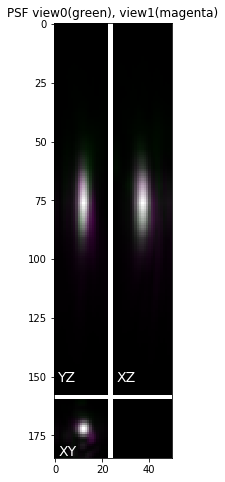

In [46]:
fig = plt.figure(figsize=(8,8))
util.show_mips(util.merge_images_rgb(psf0_img_iso_norm, psf1_img_iso_norm), "PSF view0(green), view1(magenta)")

In [52]:
# Transform PSF into data coordinate system
c0 = util.get_center(psf0_img_iso_norm, 'mass')
centering_transform0 = sitk.TranslationTransform(3)
centering_transform0.SetOffset(c0)

c1 = util.get_center(psf1_img_iso_norm, 'mass')
centering_transform1 = sitk.TranslationTransform(3)
centering_transform1.SetOffset(c1)

transform_rotY_plus45 = sitk.AffineTransform(3)
transform_rotY_plus45.Rotate(axis1=0, axis2=2, angle=np.pi/4)

transform_rotY_minus45 = sitk.AffineTransform(3)
transform_rotY_minus45.Rotate(axis1=0, axis2=2, angle=-np.pi/4)

centered_rotation_0 = sitk.Transform(centering_transform0)
centered_rotation_0.AddTransform(transform_rotY_plus45)

centered_rotation_1 = sitk.Transform(centering_transform1)
centered_rotation_1.AddTransform(transform_rotY_minus45)

In [53]:
# Apply the transform
psf0_final = util.transform_resample(psf0_img_iso_norm, centered_rotation_0)
psf1_final = util.transform_resample(psf1_img_iso_norm, centered_rotation_1)
psf1_final = util.resample_moving2fixed(psf0_final, psf1_final)

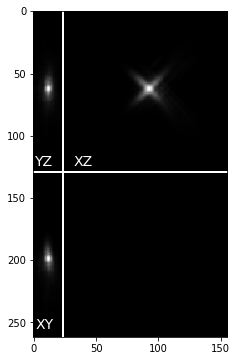

In [54]:
fig = plt.figure(figsize=(6,6))
util.show_mips(psf0_final + psf1_final)

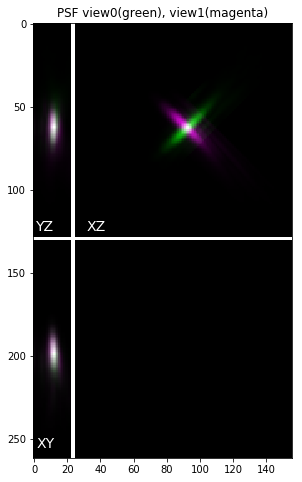

In [55]:
fig = plt.figure(figsize=(8,8))
util.show_mips(util.merge_images_rgb(psf0_final, psf1_final), "PSF view0(green), view1(magenta)")

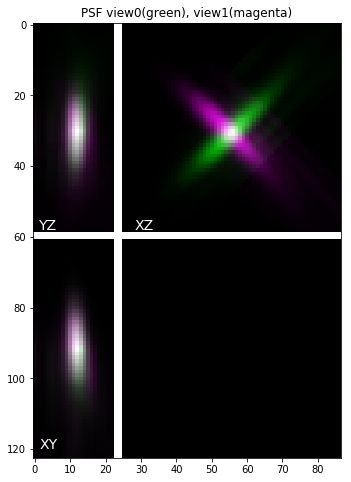

In [56]:
# crop
_, bb_size, bb_starting_ind = util.threshold_based_crop(psf0_final + psf1_final, padding_px=20)

psf0_crop = psf0_final[bb_starting_ind[0]: bb_starting_ind[0] + bb_size[0],
                      bb_starting_ind[1]: bb_starting_ind[1] + bb_size[1],
                      bb_starting_ind[2]: bb_starting_ind[2] + bb_size[2]]

psf1_crop = psf1_final[bb_starting_ind[0]: bb_starting_ind[0] + bb_size[0],
                      bb_starting_ind[1]: bb_starting_ind[1] + bb_size[1],
                      bb_starting_ind[2]: bb_starting_ind[2] + bb_size[2]]

fig = plt.figure(figsize=(8,8))
util.show_mips(util.merge_images_rgb(psf0_crop, psf1_crop), 
               "PSF view0(green), view1(magenta)")

In [57]:
psf0_final = psf0_crop
psf1_final = psf1_crop

#### Dual-view deconvolution

In [58]:
# Prepare filters for math operations
filter_conv = sitk.FFTConvolutionImageFilter()
filter_transpose = sitk.FlipImageFilter()
filter_transpose.SetFlipAxes((True,True,True))
# Prepare PSF inverse functions 
backw_projector0 = sitk.Cast(filter_transpose.Execute(psf0_final), sitk.sitkFloat32)
backw_projector1 = sitk.Cast(filter_transpose.Execute(psf1_final), sitk.sitkFloat32)

In [59]:
view0 = psf0_final
view1 = psf1_final
view0_aligned_norm = util.normalize(view0)
view1_aligned_norm = util.normalize(view1)
estimate = (view0_aligned_norm + view1_aligned_norm) / 2.0
estimate_list = [estimate]

n_iter = 25
for it in tqdm(range(n_iter)):
    view0_conv = filter_conv.Execute(estimate, psf0_final)
    view1_conv = filter_conv.Execute(estimate, psf1_final)

    a0 = sitk.Cast(view0_aligned_norm / util.normalize(view0_conv), sitk.sitkFloat32)
    a1 = sitk.Cast(view1_aligned_norm / util.normalize(view1_conv), sitk.sitkFloat32)
    
    next_view0 = filter_conv.Execute(a0, backw_projector0)
    next_view1 = filter_conv.Execute(a1, backw_projector1)
    
    estimate = estimate * ((util.normalize(next_view0) + util.normalize(next_view1)) / 2.0)
    
    estimate_list.append(estimate)

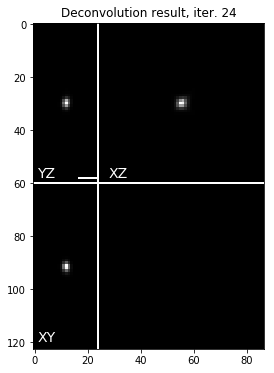

In [60]:
i = 24
fig = plt.figure(figsize=(6,6))
util.show_mips(estimate_list[i], f"Deconvolution result, iter. {i}", boundary_width=1, scalebar=1)

### Deconvolve the worm head

In [61]:
view0 = view0_cropped
view1 = view1_cropped_affine

In [62]:
view0_aligned_norm = util.normalize(view0)
view1_aligned_norm = util.normalize(view1)
estimate = (view0_aligned_norm + view1_aligned_norm) / 2.0
estimate_list = [estimate]

n_iter = 25
for it in tqdm(range(n_iter)):
    view0_conv = filter_conv.Execute(estimate, psf0_final)
    view1_conv = filter_conv.Execute(estimate, psf1_final)

    a0 = sitk.Cast(view0_aligned_norm / util.normalize(view0_conv), sitk.sitkFloat32)
    a1 = sitk.Cast(view1_aligned_norm / util.normalize(view1_conv), sitk.sitkFloat32)
    
    next_view0 = filter_conv.Execute(a0, backw_projector0)
    next_view1 = filter_conv.Execute(a1, backw_projector1)
    
    estimate = estimate * ((util.normalize(next_view0) + util.normalize(next_view1)) / 2.0)
    
    estimate_list.append(estimate)

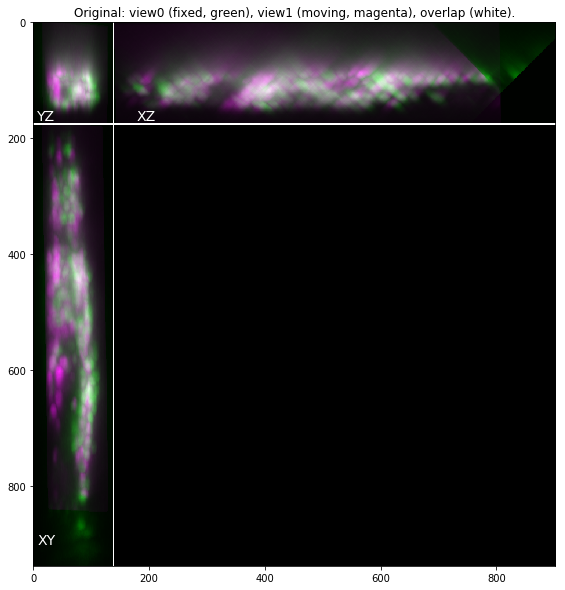

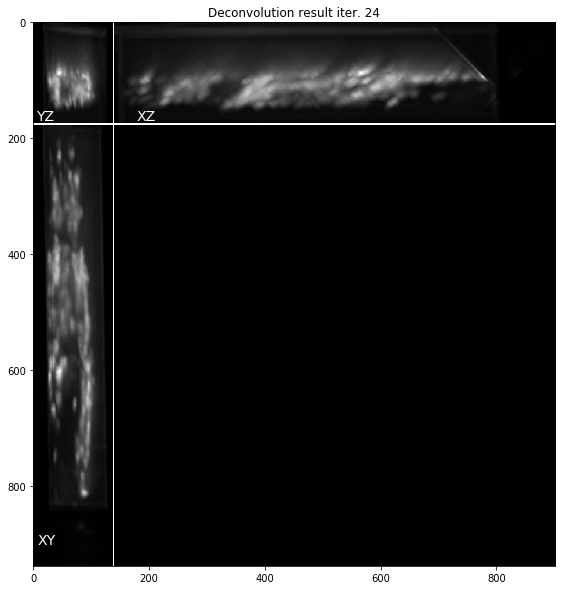

In [63]:
it = 24
fsize = 10
fig = plt.figure(figsize=(fsize,fsize))
util.show_mips(util.merge_images_rgb(view0, view1), 
               "Original: view0 (fixed, green), view1 (moving, magenta), overlap (white).")

fig = plt.figure(figsize=(fsize,fsize))
util.show_mips(estimate_list[it], f"Deconvolution result iter. {i}")

In [65]:
#save (optional)
# subfolder_name = 'decon/'
# if not os.path.exists(dirname_data + subfolder_name):
#     os.mkdir(dirname_data + subfolder_name)
# fname = dirname_data + subfolder_name + '_it25.mhd'
# sitk.WriteImage(estimate_list[-1], fname)